### Prerequisite

In [27]:
!pip install torch
!pip install torch_geometric
!pip install lightning
!pip install wandb
!pip install scikit-image
!pip install egnn-pytorch
!pip install matplotlib
!pip install seaborn
!pip install plotly

# Optional dependencies:
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!wandb login

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [28]:
import torch
import lightning as L
import wandb
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.trainer import Trainer

import torch.nn as nn
import torch.nn.functional as F
import torch.func as func
import torch.autograd.functional as AF
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
from torch_geometric.datasets import MD17
from torch_geometric.data import Data
from torch_geometric.transforms import NormalizeScale, Center, BaseTransform
from torch_geometric.loader import DataLoader, DenseDataLoader
from sklearn.datasets import make_s_curve, make_swiss_roll

import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [6]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    print("MPS is available.")

MPS not available because the current PyTorch install was not built with MPS enabled.


### Swiss Roll

In [ ]:
# Step 1: Generate the Swiss Roll dataset
n_samples = 100000
X, y = make_swiss_roll(n_samples)

X_2d = X[:, :2]

# Step 3: Convert the dataset into PyTorch tensors
X_tensor = torch.tensor(X_2d, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Step 3: Create a custom PyTorch Dataset class
class SwissRollDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return sample

# Step 4: Create an instance of the custom Dataset
swiss_roll_dataset = SwissRollDataset(X_tensor, y_tensor)

# Step 5: Create a DataLoader
batch_size = 128
data_loader = DataLoader(swiss_roll_dataset, batch_size=batch_size, shuffle=True)


### MD17

In [4]:
class RecomputePosBasedOnCenter(BaseTransform):
    def __call__(self, data: Data) -> Data:
        pos = data.pos
        
        # Calculate the center of each node
        center = pos.mean(dim=0, keepdim=True)
        
        # Recompute positions based on the center
        data.pos = pos - center
        
        return data

In [5]:
dataset = MD17(root='./dataset', name='revised benzene', transform=RecomputePosBasedOnCenter())
loader = DenseDataLoader(dataset, batch_size=256, shuffle=True)

Extracting dataset/raw/file
Processing...
Done!


In [39]:
class EBMScoreMatching(L.LightningModule):
    def __init__(self, input_dim, hidden_dims, output_dim=1):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = nn.ReLU

        # Build network
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(self.activation())
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

    def energy(self, x):
        # Energy is strictly positive
        return self.forward(x) ** 2

    def score(self, x):
        # logp = -self.energy(x).sum()
        # torch.autograd.grad(logp, x)
        return -AF.jacobian(lambda x: self.energy(x).sum(), x, create_graph=True, vectorize=True)

    def sliced_score_matching_1(self, x):
        x.requires_grad_(True)

        vectors = torch.randn_like(x)
        vectors = vectors / (torch.norm(vectors, dim=-1, keepdim=True)  + 1e-8)

        logp = -self.energy(x).sum()
        grad1 = torch.autograd.grad(logp, x, create_graph=True)[0]
        gradv = torch.sum(grad1 * vectors)
        loss1 = torch.sum(grad1 * vectors, dim=-1) ** 2 * 0.5
        grad2 = torch.autograd.grad(gradv, x, create_graph=True)[0]
        loss2 = torch.sum(vectors * grad2, dim=-1)

        loss = loss1 + loss2

        return loss.mean()

    def sliced_score_matching_loss(self, x, num_slices=30):
        x.requires_grad_(True)
        x = x.reshape(-1, 1, self.input_dim).expand(-1, num_slices, -1).reshape(-1, self.input_dim)

        # Random projections
        vectors = torch.randn_like(x, device=x.device)
        vectors = vectors / (torch.norm(vectors, dim=-1, keepdim=True) + 1e-8)

        score, Jv = AF.vjp(self.score, x, vectors, create_graph=True)

        v_score = torch.sum(vectors * score, dim=-1)
        v_Jv = torch.sum(vectors * Jv, dim=-1)

        loss = (v_score ** 2).mean() * 0.5 + v_Jv.mean()

        return loss

    def training_step(self, batch, batch_idx):
        x = batch.pos.reshape(-1, self.input_dim)
        loss = self.sliced_score_matching_1(x)
        self.log('ssm_train_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.001)

In [99]:
class ScoreNet(L.LightningModule):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = input_dim
        self.activation = nn.ReLU

        # Build network
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(self.activation())
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, self.output_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
    
    def sliced_score_matching_vr(self, x, num_slices=5):
        #
        x.requires_grad_(True)
        
        # Generate random projections
        x = x.reshape(-1, 1, self.input_dim).expand(-1, num_slices, -1).reshape(-1, self.input_dim)

        vectors = torch.randn_like(x)
        vectors = vectors.to(x)
        vectors = vectors / (torch.norm(vectors, dim=-1, keepdim=True)  + 1e-8)

        score_x, Jv = AF.jvp(self.forward, x, vectors, create_graph=True, strict=True)

        loss_1 = torch.sum(Jv * vectors, dim=-1)
        loss_2 = torch.linalg.norm(score_x, dim=-1) ** 2 * 0.5

        loss = loss_1 + loss_2
        return loss.mean()

    def sliced_score_matching(self, x, num_slices=5):
        # Generate random projections
        x = x.reshape(-1, 1, self.input_dim).expand(-1, num_slices, -1).reshape(-1, self.input_dim)

        vectors = torch.randn_like(x)
        vectors = vectors.to(x)
        vectors = vectors / (torch.norm(vectors, dim=-1, keepdim=True)  + 1e-8)

        # Compute the score and its Jacobian
        h_x, h_x_v = AF.jvp(self.forward, x, vectors, create_graph=True)

        loss_1 = torch.sum(h_x_v * vectors, dim=-1)
        loss_2 = torch.sum(h_x * vectors, dim=-1) ** 2 * 0.5

        loss = loss_1 + loss_2
        loss = loss.mean()

        return loss

    def training_step(self, batch, batch_idx):
        x = batch.pos.reshape(-1, self.input_dim)
        loss = self.sliced_score_matching_vr(x)
        self.log('ssm_train_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=1e-3)

In [6]:
from egnn_pytorch import EGNN

class ScoreNetEGNN(L.LightningModule):
    def __init__(self, dims):
        super().__init__()
        self.dims = dims

        # Build network
        self.net = nn.ModuleList()
        for hidden_dim in dims:
            self.net.append(EGNN(dim=hidden_dim, m_dim=64))

        # Remove the last layer from self.net
        self.net = self.net[:-1]

    def forward(self, x):
        feats = torch.zeros(x.shape[0], x.shape[1], self.dims[0]).to(x.device)
        coords = x

        for layer in self.net:
            feats, coords = layer(feats, coords)

        return coords
    
    def sliced_score_matching_vr(self, x, num_slices=5):
        x.requires_grad_(True)
        
        # Generate random projections
        x = x.reshape(-1, 1, x.shape[1], 3).expand(-1, num_slices, -1, -1).reshape(-1, x.shape[1], 3)

        vectors = torch.randn_like(x)
        vectors = vectors / (torch.norm(vectors, dim=-1, keepdim=True) + 1e-8)

        score_x, Jv = AF.jvp(self.forward, x, vectors, create_graph=True)

        loss_1 = torch.sum(Jv * vectors, dim=-1)
        loss_2 = torch.linalg.norm(score_x, dim=-1) ** 2 * 0.5

        loss = loss_1 + loss_2
        return loss.mean()

    def training_step(self, batch, batch_idx):
        x = batch.pos
        loss = self.sliced_score_matching_vr(x)
        self.log('ssm_train_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=1e-3)

In [170]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇█▁▁▁▂▂▂▂▃▃▁▁▁
ssm_train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇█▇
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██▁▁▂▂▂▂▃▃▃▁▁▁
epoch,0
ssm_train_loss,21169.45898
trainer/global_step,849


In [7]:
model = ScoreNetEGNN(
    dims=[16, 16, 16]
)

wandb_logger = WandbLogger(project='ebm', log_model="all")

if not torch.backends.mps.is_available():
    trainer = Trainer(max_epochs=100, logger=wandb_logger)
else:
    trainer = Trainer(max_epochs=100, logger=wandb_logger, accelerator="mps", devices=1)

trainer.fit(model, loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: wc5118 (iclac). Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | ModuleList | 53.1 K | train
--------------------------------------------
53.1 K    Trainable params
0         Non-trainable params
53.1 K    Total params
0.212     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
model = ScoreNet(
    input_dim=12*3,
    hidden_dims=[128, 128, 128],
)

In [23]:
wandb_logger = WandbLogger(project='ebm', log_model="all")

if not torch.backends.mps.is_available():
    trainer = Trainer(max_epochs=100, logger=wandb_logger)
else:
    trainer = Trainer(max_epochs=100, logger=wandb_logger, accelerator="mps", devices=1)

trainer.fit(model, loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory ./ebm/ej4htzkf/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | ModuleList | 53.1 K | train
--------------------------------------------
53.1 K    Trainable params
0         Non-trainable params
53.1 K    Total params
0.212     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'tra

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [8]:
for batch in loader:
  x = batch
  break

## Data Visualisation

In [9]:
# Concat the data in each batch
for batch in loader:
    break

x = batch.pos
energy = batch.energy

for idx, batch in enumerate(loader):
    if idx > 10:
        break
    x = torch.cat((x, batch.pos), dim=0)
    energy = torch.cat((energy, batch.energy), dim=0)

energy = energy - energy.min()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [13]:
def plot_energy_histogram(energy, bins=50, title="Distribution of Energy Values"):
    """
    Plot a histogram of energy values.
    
    Parameters:
    - energy: torch tensor or numpy array of energy values
    - bins: number of bins for the histogram (default: 50)
    - title: title for the plot (default: "Distribution of Energy Values")
    """
    # Convert to numpy if it's a torch tensor
    if isinstance(energy, torch.Tensor):
        energy = energy.cpu().numpy()
    
    plt.figure(figsize=(10, 6))
    
    # Plot the histogram
    n, bins, patches = plt.hist(energy, bins=bins, edgecolor='black')
    
    # Add labels and title
    plt.xlabel('Energy')
    plt.ylabel('Frequency')
    plt.title(title)
    
    # Add some statistics
    mean_energy = np.mean(energy)
    median_energy = np.median(energy)
    std_energy = np.std(energy)
    
    stats_text = f'Mean: {mean_energy:.2f}\nMedian: {median_energy:.2f}\nStd Dev: {std_energy:.2f}'
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [14]:
def visualize_stein_scores(particle_positions, stein_scores, sample_size=100, arrow_scale=1.0):
    """
    Visualize Stein scores as arrows in 3D space.

    Parameters:
    - particle_positions: numpy array of shape (num_particles, 3) containing particle positions
    - stein_scores: numpy array of shape (num_particles, 3) containing Stein scores for each particle
    - sample_size: number of particles to visualize (to avoid overcrowding)
    - arrow_scale: scaling factor for arrow sizes
    """

    num_particles = particle_positions.shape[0]

    # Randomly sample particles if there are too many
    if num_particles > sample_size:
        indices = np.random.choice(num_particles, sample_size, replace=False)
        positions = particle_positions[indices]
        scores = stein_scores[indices]
    else:
        positions = particle_positions
        scores = stein_scores

    # Create the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot particles
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='blue', s=20, alpha=0.6)

    # Plot Stein score arrows
    ax.quiver(positions[:, 0], positions[:, 1], positions[:, 2],
              scores[:, 0], scores[:, 1], scores[:, 2],
              color='red', alpha=0.8, arrow_length_ratio=0.3,
              length=arrow_scale, normalize=True)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Particle Positions and Stein Scores')

    # Add a legend
    ax.scatter([], [], [], c='blue', s=20, label='Particles')
    ax.quiver([], [], [], [], [], [], color='red', label='Stein Scores')
    ax.legend()

    # Improve the view angle
    ax.view_init(elev=20, azim=45)

    plt.tight_layout()
    plt.show()

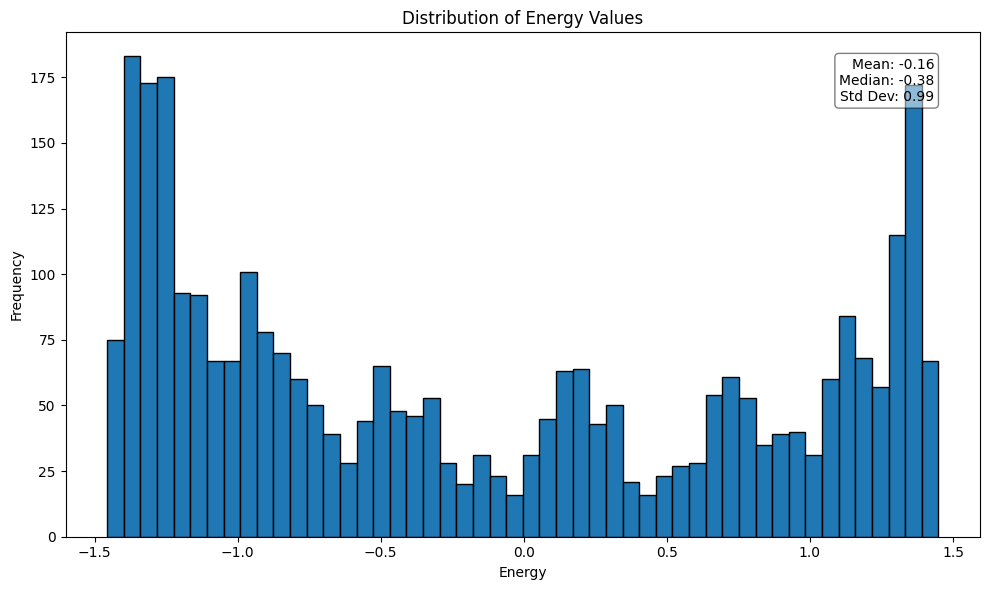

In [16]:
plot_energy_histogram(x[:, 0, 0].reshape(-1, 1))

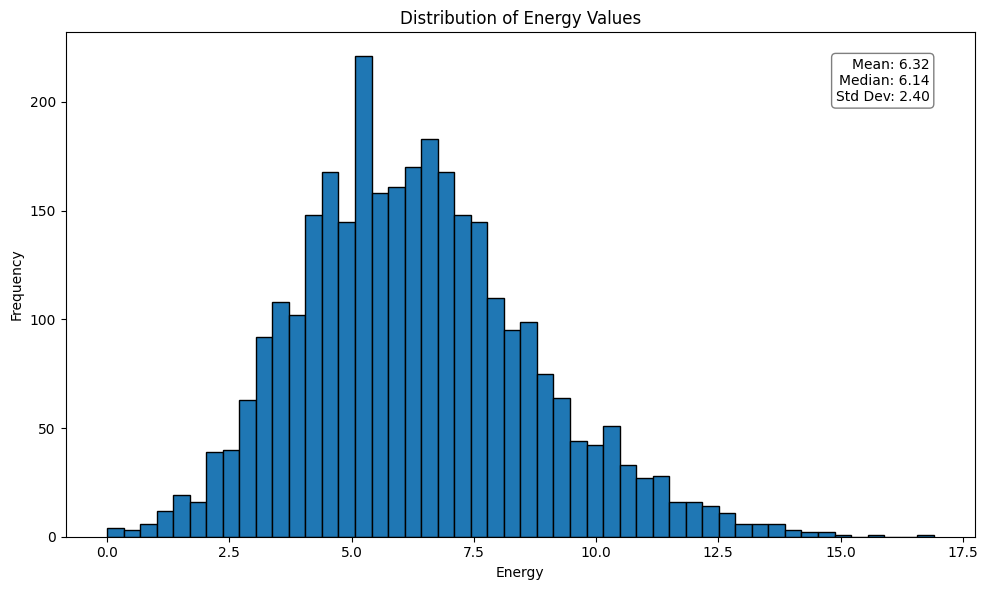

In [17]:
plot_energy_histogram(energy, bins=50)

In [46]:
def visualize_stein_scores_with_forces(particle_positions, stein_scores, forces, sample_size=100, arrow_scale=1.0):
    """
    Visualize Stein scores as arrows in 3D space.

    Parameters:
    - particle_positions: numpy array of shape (num_particles, 3) containing particle positions
    - stein_scores: numpy array of shape (num_particles, 3) containing Stein scores for each particle
    - forces: numpy array of shape (num_particles, 3) containing forces for each particle
    - sample_size: number of particles to visualize (to avoid overcrowding)
    - arrow_scale: scaling factor for arrow sizes
    """

    num_particles = particle_positions.shape[0]

    # Randomly sample particles if there are too many
    if num_particles > sample_size:
        indices = np.random.choice(num_particles, sample_size, replace=False)
        positions = particle_positions[indices]
        scores = stein_scores[indices]
    else:
        positions = particle_positions
        scores = stein_scores

    # Create the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot particles
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='blue', s=20, alpha=0.6)

    # Plot Stein score arrows
    ax.quiver(positions[:, 0], positions[:, 1], positions[:, 2],
              scores[:, 0], scores[:, 1], scores[:, 2],
              color='red', alpha=0.8, arrow_length_ratio=0.3,
              length=arrow_scale, normalize=True)
    
    # Plot forces
    ax.quiver(positions[:, 0], positions[:, 1], positions[:, 2],
              forces[:, 0], forces[:, 1], forces[:, 2],
              color='green', alpha=0.8, arrow_length_ratio=0.3,
              length=arrow_scale, normalize=True)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Particle Positions and Stein Scores')

    # Add a legend
    ax.scatter([], [], [], c='blue', s=20, label='Particles')
    ax.quiver([], [], [], [], [], [], color='red', label='Stein Scores')
    ax.quiver([], [], [], [], [], [], color='green', label='Ground Truth Forces')
    ax.legend()

    # Improve the view angle
    ax.view_init(elev=20, azim=45)

    plt.tight_layout()
    plt.show()

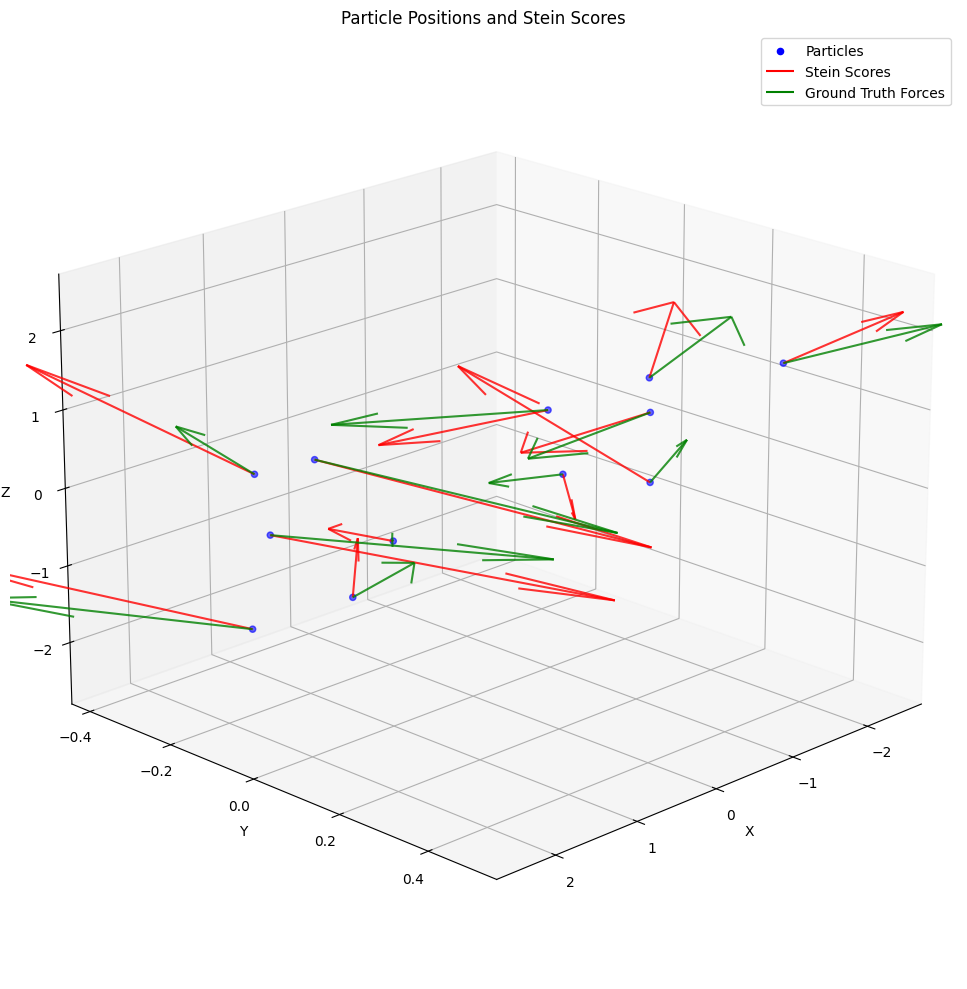

In [24]:
x = batch.pos.to(model.device)
scores = model.forward(x)
forces = batch.force
idx = 10

visualize_stein_scores_with_forces(x.cpu().detach().numpy()[idx], scores.cpu().detach().numpy()[idx], forces.cpu().detach().numpy()[idx])

In [51]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output

def create_interactive_molecule_plot(particle_positions, forces, scores):
    num_molecules, num_particles, dim = particle_positions.shape
    assert dim == 3, "Expected 3D coordinates for particles"

    def plot_molecule(molecule_idx):
        clear_output(wait=True)
        positions = particle_positions[molecule_idx]
        force = forces[molecule_idx]
        score = scores[molecule_idx]

        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot particles
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='blue', s=20, label='Particles')

        # Plot forces (green arrows)
        ax.quiver(positions[:, 0], positions[:, 1], positions[:, 2],
                  force[:, 0], force[:, 1], force[:, 2],
                  color='green', label='Forces', arrow_length_ratio=0.3, normalize=True)

        # Plot scores (red arrows)
        ax.quiver(positions[:, 0], positions[:, 1], positions[:, 2],
                  score[:, 0], score[:, 1], score[:, 2],
                  color='red', label='Scores', arrow_length_ratio=0.3, normalize=True)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Molecule Visualization (Datapoint: {molecule_idx})')
        ax.legend()

        # Set aspect ratio to be equal
        ax.set_box_aspect((np.ptp(positions[:, 0]), np.ptp(positions[:, 1]), np.ptp(positions[:, 2])))

        plt.tight_layout()
        plt.show()

    # Create widget for molecule selection
    molecule_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=num_molecules-1,
        step=1,
        description='Molecule:',
        continuous_update=False
    )

    # Create interactive output
    interactive_plot = widgets.interactive(plot_molecule, molecule_idx=molecule_slider)
    
    # Display the interactive plot
    display(interactive_plot)


In [52]:
create_interactive_molecule_plot(x.cpu().detach().numpy(), forces.cpu().detach().numpy(), scores.cpu().detach().numpy())

interactive(children=(IntSlider(value=0, continuous_update=False, description='Molecule:', max=255), Output())…

In [74]:
def stein_score_function(x):
    return model.forward(x.reshape(1,3)).reshape(-1, 3)

def generate_and_visualize_trajectory(initial_positions, num_steps, model, step_size=0.01):
    """
    Generate a trajectory based on Stein scores and visualize it.

    Parameters:
    - initial_positions: torch tensor of shape (num_particles, 3) containing initial particle positions
    - num_steps: number of steps in the trajectory
    - model: PyTorch model used to compute Stein scores
    - step_size: size of each step
    - stein_score_function: function that computes Stein scores given particle positions
    """

    # Ensure model is in evaluation mode
    model.eval()

    # Move initial positions to the same device as the model
    device = model.device
    initial_positions = initial_positions.to(device)
    
    num_particles = initial_positions.shape[0]
    trajectory = torch.zeros((num_steps + 1, num_particles, 3), device=device)
    trajectory[0] = initial_positions

    # Generate trajectory
    with torch.no_grad():
        for step in range(1, num_steps + 1):
            scores = model.forward(trajectory[step - 1].unsqueeze(0).reshape(1, -1)).squeeze(0).reshape(-1, 3)
            trajectory[step] = trajectory[step - 1] + step_size * scores

    # Move trajectory to CPU for visualization
    trajectory_np = trajectory.cpu().numpy()

    # Visualize trajectory
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot initial positions
    ax.scatter(trajectory_np[0, :, 0], trajectory_np[0, :, 1], trajectory_np[0, :, 2],
               c='blue', s=30, label='Initial')

    # Plot final positions
    ax.scatter(trajectory_np[-1, :, 0], trajectory_np[-1, :, 1], trajectory_np[-1, :, 2],
               c='red', s=30, label='Final')

    # Plot trajectories
    for i in range(num_particles):
        ax.plot(trajectory_np[:, i, 0], trajectory_np[:, i, 1], trajectory_np[:, i, 2],
                c='gray', alpha=0.5)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Particle Trajectories')

    ax.legend()

    # Improve the view angle
    ax.view_init(elev=20, azim=45)

    plt.tight_layout()
    plt.show()

    return trajectory

# Example usage:
# initial_positions = torch.tensor([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]], dtype=torch.float32)
# num_steps = 100
# trajectory = generate_and_visualize_trajectory(initial_positions, num_steps, model)


In [76]:
initial_positions = x[0]

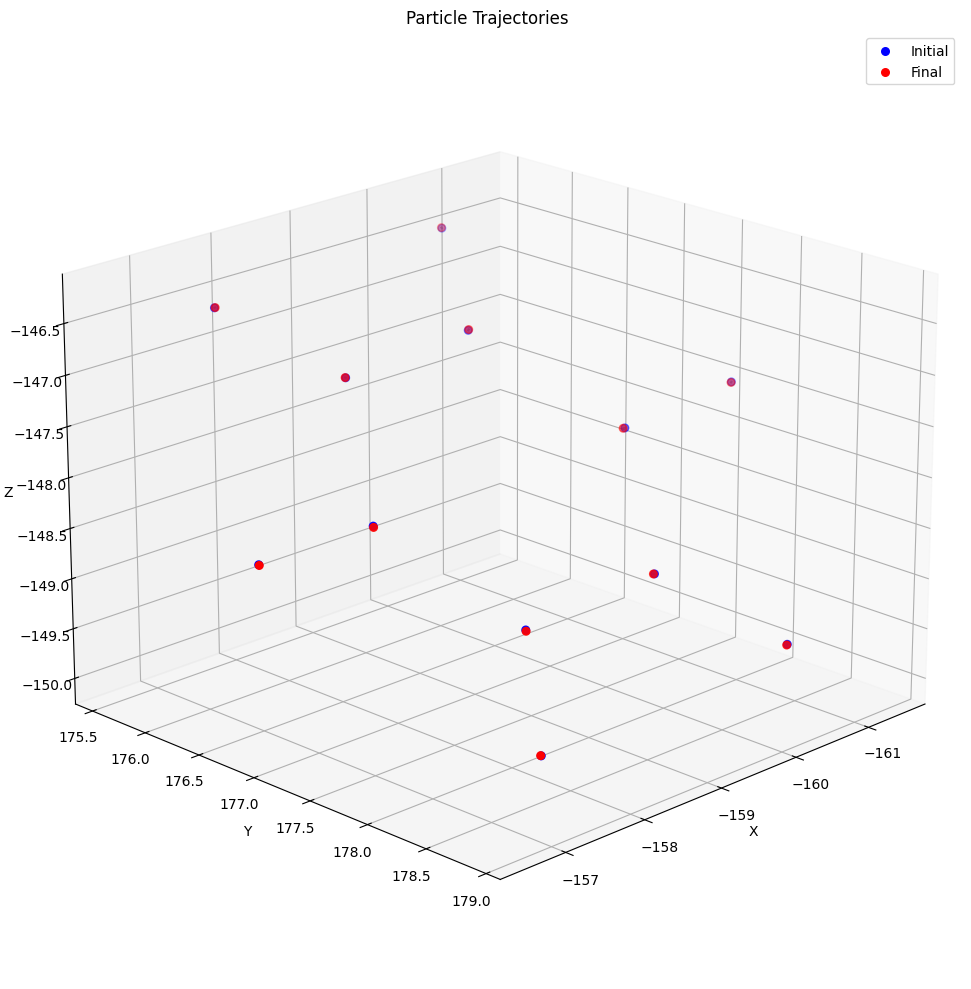

In [82]:
final = generate_and_visualize_trajectory(x[7], 300, model, step_size=1)

In [172]:
def visualize_stein_vectors(points, vectors):
    """
    Visualize pre-calculated Stein vectors in 3D space.
    
    Parameters:
    - points: numpy array of shape (n, 3) containing the coordinates of points
    - vectors: numpy array of shape (n, 3) containing the vector components at each point
    """
    # Unpack points and vectors
    X, Y, Z = points.T
    U, V, W = vectors.T

    # Create the 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the vectors
    ax.quiver(X, Y, Z, U, V, W, length=1, normalize=True)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Stein Score Vector Field Visualization')

    # Set the same scale for all axes
    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Show the plot
    plt.show()

In [173]:
x = batch.pos.to(model.device).reshape(-1, 12*3)
score = model.forward(x).reshape(-1, 3)
x = x.reshape(-1, 3)

In [66]:
visualize_stein_scores(x.cpu().detach().numpy()[:12], score.cpu().detach().numpy()[:12])

NameError: name 'score' is not defined

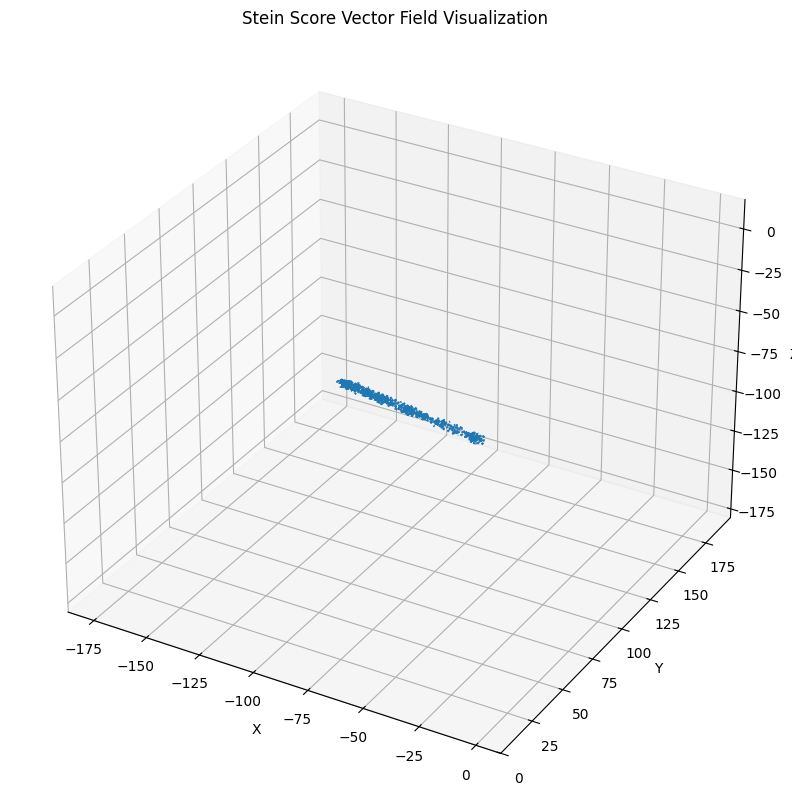

In [174]:
visualize_stein_vectors(x.cpu().detach().numpy(), score.cpu().detach().numpy())

In [180]:
def visualize_molecules_in_configuration_space(molecules):
    """
    Visualize molecules in the configuration space using PCA.

    Parameters:
    - molecules: torch tensor of shape (batch, num_particles, 3) containing molecule data
    """

    # Move molecules to CPU if they are on a GPU
    molecules = molecules.cpu().numpy()

    # Flatten each molecule to a single vector
    batch_size, num_particles, _ = molecules.shape
    flattened_molecules = molecules.reshape(batch_size, -1)

    # Apply PCA to reduce to 2 or 3 dimensions
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(flattened_molecules)

    # Plot the PCA-transformed data
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c='blue', s=30, label='Molecules')

    # Set labels and title
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.set_title('Molecules in Configuration Space')

    ax.legend()

    # Improve the view angle
    ax.view_init(elev=20, azim=45)

    plt.tight_layout()
    plt.show()


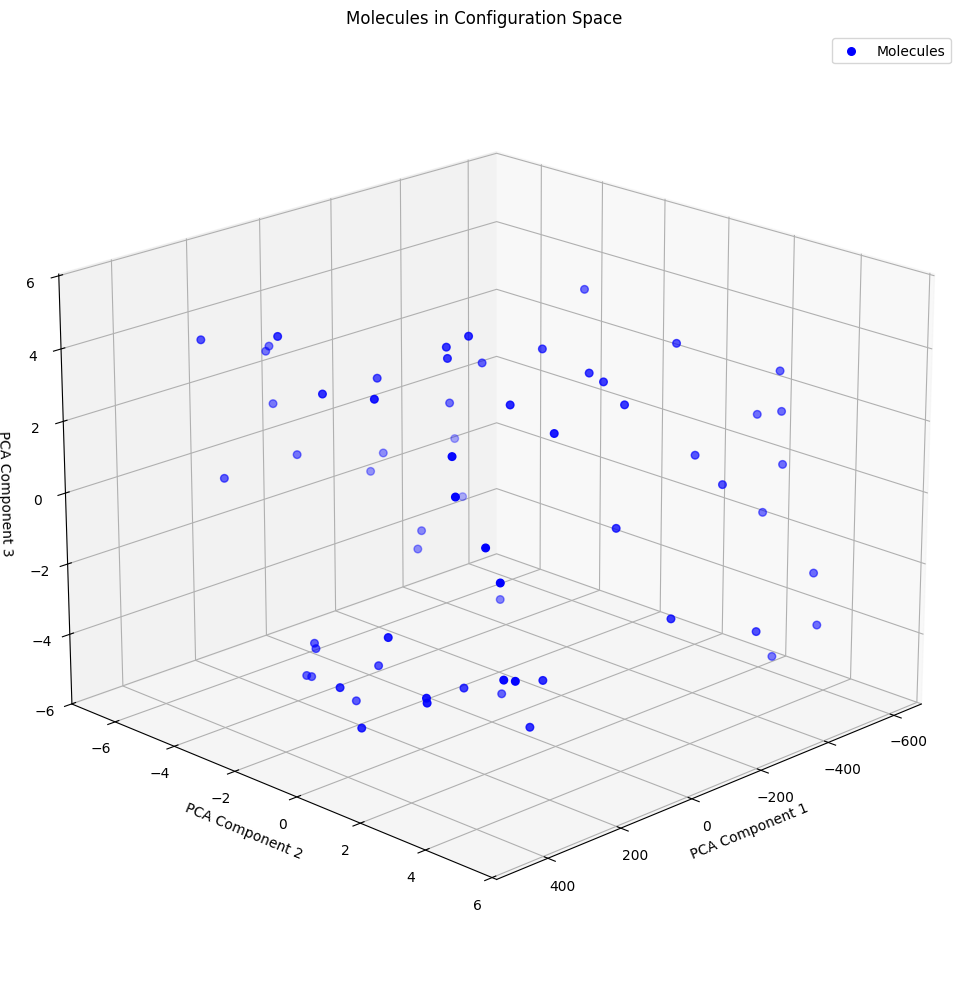

In [182]:
visualize_molecules_in_configuration_space(x.reshape(-1, 12, 3))

In [13]:
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def visualize_energy_landscape(molecules, energies):
    """
    Visualize the energy landscape of molecules in the configuration space using PCA and Gaussian Process Regression.

    Parameters:
    - molecules: torch tensor of shape (batch, num_particles, 3) containing molecule data
    - energies: numpy array of shape (batch,) containing energy labels
    """

    # Move molecules to CPU if they are on a GPU
    molecules = molecules.cpu().numpy()

    # Flatten each molecule to a single vector
    batch_size, num_particles, _ = molecules.shape
    flattened_molecules = molecules.reshape(batch_size, -1)

    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(flattened_molecules)

    # Fit a Gaussian Process to the PCA components and energy labels
    kernel = RBF(length_scale=1.0)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
    gp.fit(pca_result, energies)

    # Create a grid for interpolation
    grid_size = 100
    x = np.linspace(np.min(pca_result[:, 0]), np.max(pca_result[:, 0]), grid_size)
    y = np.linspace(np.min(pca_result[:, 1]), np.max(pca_result[:, 1]), grid_size)
    X, Y = np.meshgrid(x, y)
    grid_points = np.vstack([X.ravel(), Y.ravel()]).T

    # Predict energy values on the grid
    energy_pred, sigma = gp.predict(grid_points, return_std=True)
    energy_pred = energy_pred.reshape(grid_size, grid_size)

    # Visualize the energy landscape
    plt.figure(figsize=(12, 10))

    # Plot the energy landscape
    plt.contourf(X, Y, energy_pred, levels=100, cmap='viridis')
    plt.colorbar(label='Energy')

    # Scatter plot of the PCA components colored by the actual energy values
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=energies, cmap='viridis', edgecolor='k', s=30, label='Molecules')

    # Set labels and title
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Energy Landscape in Configuration Space')

    plt.tight_layout()
    plt.show()


In [52]:
from sklearn.preprocessing import KBinsDiscretizer

def create_diverse_subset(x, energy, n_bins=20, samples_per_bin=50):
    """
    Create a diverse subset of the data that covers the entire energy range.
    
    Parameters:
    - x: torch tensor of shape (n_samples, n_features)
    - energy: torch tensor of shape (n_samples,)
    - n_bins: number of bins to divide the energy range into
    - samples_per_bin: number of samples to select from each bin
    
    Returns:
    - x_subset: torch tensor of shape (n_subset_samples, n_features)
    - energy_subset: torch tensor of shape (n_subset_samples,)
    """
    # Convert to numpy for easier manipulation
    x_np = x.cpu().numpy()
    energy_np = energy.cpu().numpy()
    
    # Create bins
    kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    energy_binned = kbd.fit_transform(energy_np.reshape(-1, 1)).flatten()
    
    x_subset = []
    energy_subset = []
    
    # Sample from each bin
    for bin_idx in range(n_bins):
        bin_mask = (energy_binned == bin_idx)
        bin_x = x_np[bin_mask]
        bin_energy = energy_np[bin_mask]
        
        if len(bin_x) > 0:
            # Randomly sample from this bin
            sample_size = min(samples_per_bin, len(bin_x))
            sample_indices = np.random.choice(len(bin_x), size=sample_size, replace=False)
            
            x_subset.append(bin_x[sample_indices])
            energy_subset.append(bin_energy[sample_indices])
    
    # Concatenate all samples
    x_subset = np.concatenate(x_subset)
    energy_subset = np.concatenate(energy_subset)
    
    # Convert back to torch tensors
    x_subset = torch.tensor(x_subset, dtype=x.dtype, device=x.device)
    energy_subset = torch.tensor(energy_subset, dtype=energy.dtype, device=energy.device)
    
    return x_subset, energy_subset

In [46]:
x_subset, energy_subset = create_diverse_subset(x, energy, n_bins=20, samples_per_bin=50)

/Users/chenwuhao/Documents/dev/ebm-sampling/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


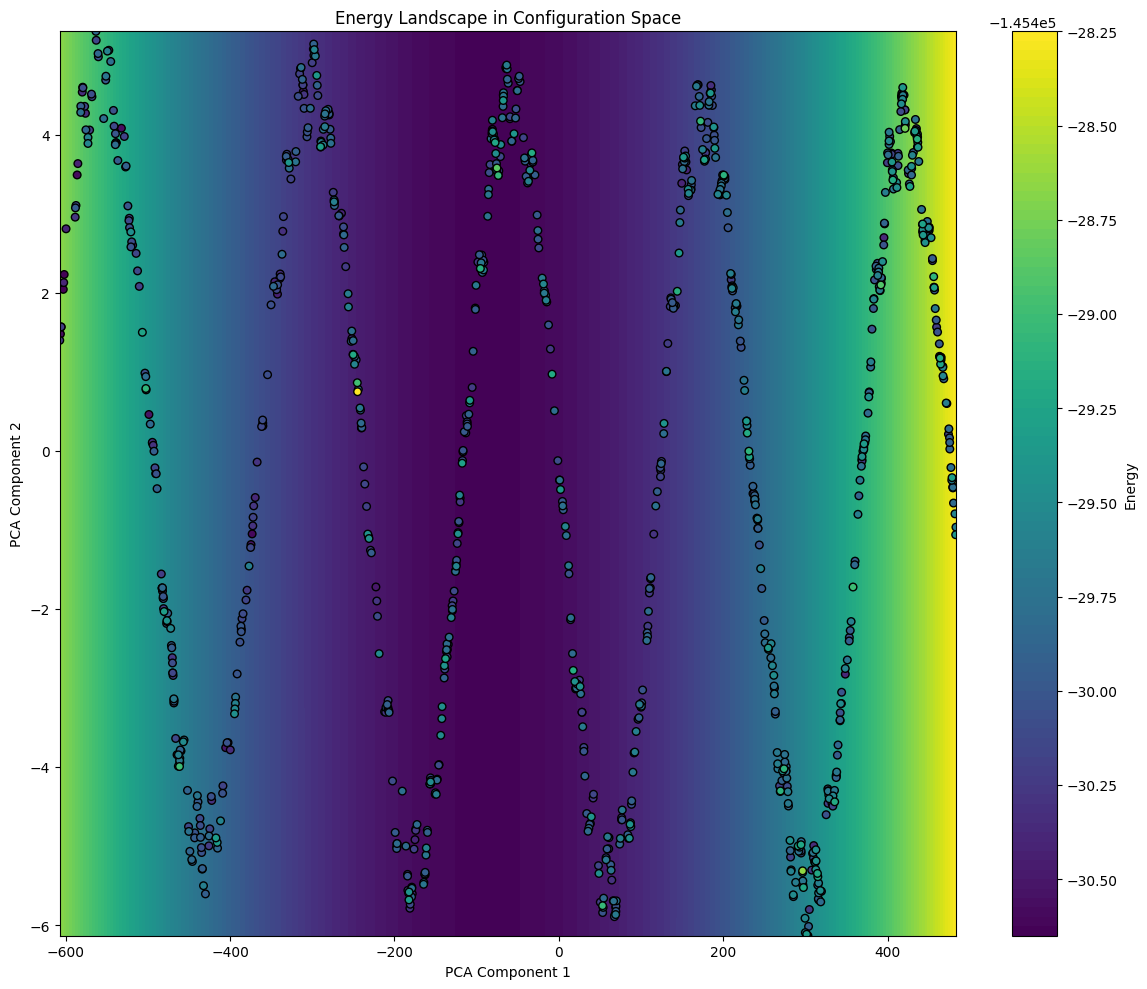

In [53]:
visualize_energy_landscape(x_subset, energy_subset)

In [38]:
from skimage import measure
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.interpolate import griddata
import warnings

def visualize_energy_landscape_3d(molecules, energies):
    """
    Visualize the energy landscape of molecules in the configuration space using PCA and Gaussian Process Regression.
    PCA is used to reduce to 2D, and the smoothed energy is used as the third dimension.

    Parameters:
    - molecules: torch tensor of shape (batch, num_particles, 3) containing molecule data
    - energies: numpy array of shape (batch,) containing energy labels
    """
    try:
        # Move molecules to CPU if they are on a GPU
        molecules = molecules.cpu().numpy()

        # Flatten each molecule to a single vector
        batch_size, num_particles, _ = molecules.shape
        flattened_molecules = molecules.reshape(batch_size, -1)

        # Apply PCA to reduce to 2 dimensions
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(flattened_molecules)

        # Fit a Gaussian Process to the PCA components and energy labels
        kernel = C(1.0, (1e-3, 1e3)) * RBF([1.0, 1.0], (1e-2, 1e2))
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gp.fit(pca_result, energies)

        # Create a grid for interpolation
        grid_size = 100
        x = np.linspace(np.min(pca_result[:, 0]), np.max(pca_result[:, 0]), grid_size)
        y = np.linspace(np.min(pca_result[:, 1]), np.max(pca_result[:, 1]), grid_size)
        X, Y = np.meshgrid(x, y)
        grid_points = np.vstack([X.ravel(), Y.ravel()]).T

        # Predict energy values on the grid
        Z, sigma = gp.predict(grid_points, return_std=True)
        Z = Z.reshape(grid_size, grid_size)

        # Visualize the energy landscape
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Surface plot of the smoothed energy landscape
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='none')
        fig.colorbar(surf, ax=ax, label='Predicted Energy', shrink=0.6)

        # Scatter plot of the original data points with a different colormap
        scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], energies, 
                             c=energies, cmap='plasma', s=50, label='Molecules')
        cbar_scatter = fig.colorbar(scatter, ax=ax, label='Actual Energy', shrink=0.6, pad=0.08)
        

        # Set labels and title
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.set_zlabel('Energy')
        ax.set_title('Energy Landscape in Configuration Space')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Please check your input data and ensure it's suitable for PCA and GP regression.")

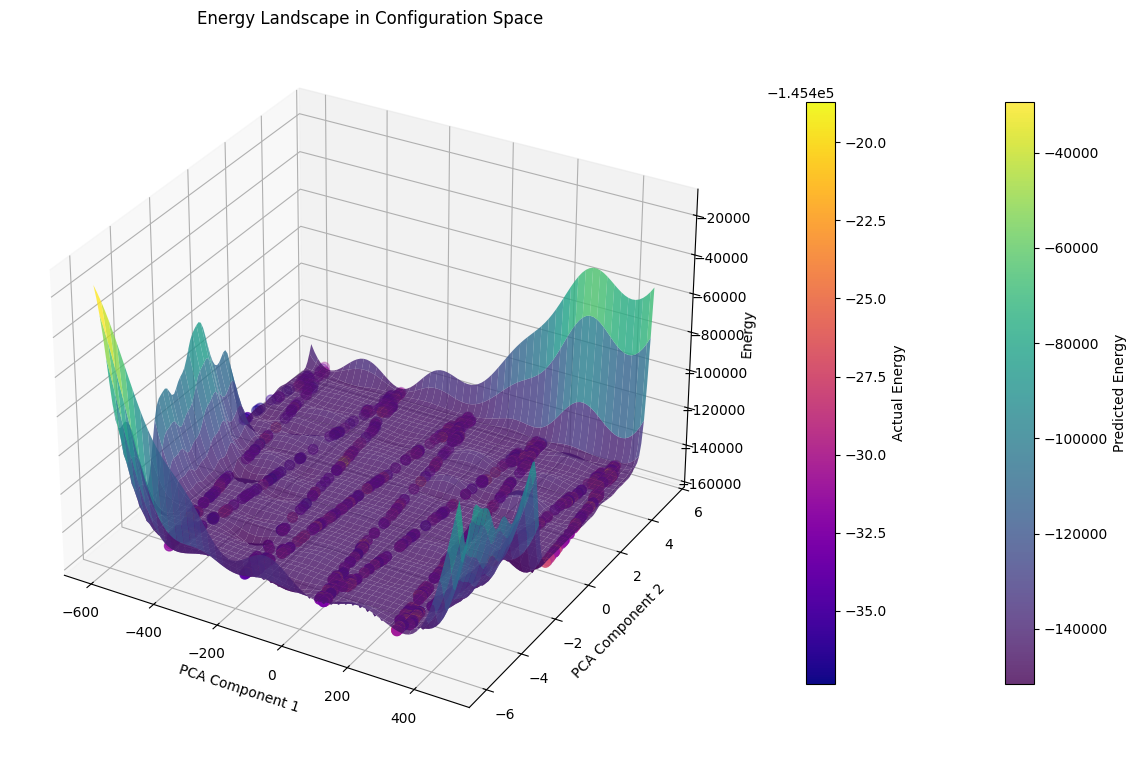

In [49]:
visualize_energy_landscape_3d(x_subset, energy_subset.squeeze())

In [64]:
from sklearn.decomposition import KernelPCA
def visualize_energy_landscape_3(molecules, energies):
    """
    Visualize the energy landscape of molecules in the configuration space using PCA.

    Parameters:
    - molecules: torch tensor of shape (batch, num_particles, 3) containing molecule data
    - energies: numpy array of shape (batch,) containing energy labels
    """

    # Move molecules to CPU if they are on a GPU
    molecules = molecules.cpu().numpy()

    # Flatten each molecule to a single vector
    batch_size, num_particles, _ = molecules.shape
    flattened_molecules = molecules.reshape(batch_size, -1)

    # Apply PCA to reduce to 3 dimensions
    pca = KernelPCA(n_components=3, kernel='sigmoid', gamma=0.1)
    pca_result = pca.fit_transform(flattened_molecules)

    # Visualize the energy landscape
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of the PCA components colored by the actual energy values
    scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=energies, cmap='viridis', s=30)
    fig.colorbar(scatter, ax=ax, label='Energy')

    # Set labels and title
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.set_title('Energy Landscape in Configuration Space')

    plt.tight_layout()
    plt.show()

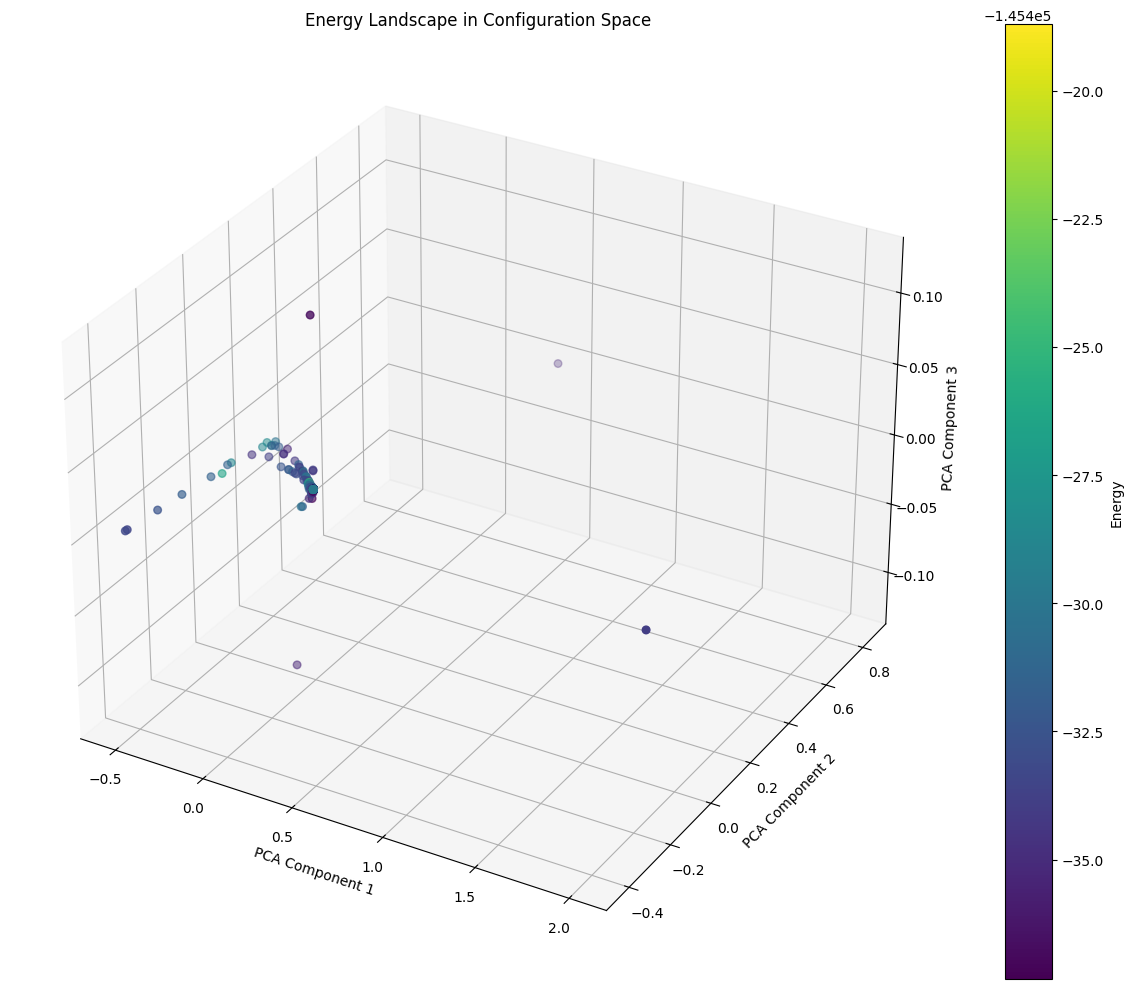

In [65]:
visualize_energy_landscape_3(x_subset, energy_subset.squeeze())